In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf

In [2]:
# loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# data pre-processing
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

In [4]:
# offcet for takung in to account sigmoida assimptitoty
X_train = (X_train/255.0 * 0.99) + 0.01
X_test = (X_test/255.0 * 0.99) + 0.01

In [5]:
# data normalization
# dataset has images with pixel values in the range [0, 255] - for the [0,1] scaling, you simply divide by 255
# X_train = X_train/255
# X_test = X_test/255

In [6]:
# data pre-processing - reshaping (The first number is the number of images, Then comes the shape of each image (28x28). The last number is 1, which signifies that the images are greyscale.)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [7]:
# X_train_deskewed = X_train_deskewed.reshape(-1,28,28,1)
# X_test_deskewed = X_test_deskewed.reshape(-1,28,28,1)

# X_train_deskewed.shape, X_test_deskewed.shape

### Deskewing & normalization

In [8]:
# deskewing images + normalization
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_train_deskewed = deskewAll(X_train)
X_test_deskewed = deskewAll(X_test)

In [9]:
X_train_deskewed = X_train_deskewed.reshape(-1,28,28,1)
X_test_deskewed = X_test_deskewed.reshape(-1,28,28,1)

X_train_deskewed.shape, X_test_deskewed.shape

In [10]:
# one-hot encoding - create a column for each output category and a binary variable is inputted for each category
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10)
y_train.shape

Using TensorFlow backend.


(42000, 10)

In [11]:
# splitting test and train datasets with 10% for test
#from sklearn.model_selection import train_test_split
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

## Building a Convolutional Neural Network (CNN) in Keras
### Sequential model

In [12]:
# sequential allows you to build a model layer by layer.
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


* Our first 2 layers are Conv2D layers. These are convolution layers that will deal with our input images, which are seen as 2-dimensional matrices.
* 64 in the first layer and 32 in the second layer are the number of nodes in each layer. This number can be adjusted to be higher or lower, depending on the size of the dataset. In our case, 64 and 32 work well, so we will stick with this for now.

* Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix. Refer back to the introduction and the first image for a refresher on this.

* Activation is the activation function for the layer. The activation function we will be using for our first 2 layers is the ReLU, or Rectified Linear Activation. This activation function has been proven to work well in neural networks.

* Our first layer also takes in an input shape. This is the shape of each input image, 28,28,1 as seen earlier on, with the 1 signifying that the images are greyscale.

* In between the Conv2D layers and the dense layer, there is a ‘Flatten’ layer. Flatten serves as a connection between the convolution and dense layers.

* ‘Dense’ is the layer type we will use in for our output layer. Dense is a standard layer type that is used in many cases for neural networks.

* We will have 10 nodes in our output layer, one for each possible outcome (0–9).

* The activation is ‘softmax’. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [13]:
# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# training the model, 7 epochs
history = model.fit(X_train_deskewed, y_train, epochs=25) # validation_data=(X_cv,y_cv),

42000/42000 [==============================] - 68s 2ms/step - loss: 0.0087 - accuracy: 0.9971


* Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.
* The learning rate determines how fast the optimal weights for the model are calculated. 
* We will use ‘categorical_crossentropy’ for our loss function. This is the most common choice for classification. A lower score indicates that the model is performing better.
* We will use the ‘accuracy’ metric to see the accuracy score on the validation set when we train the model.

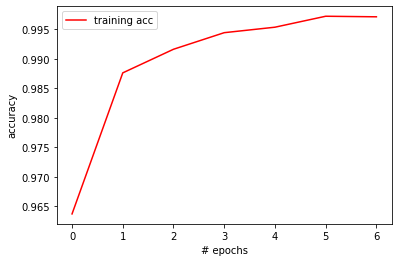

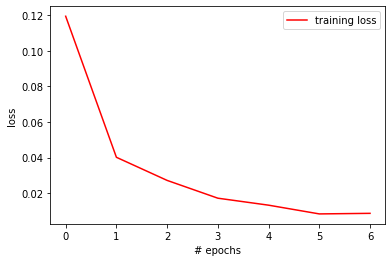

In [14]:
plt.plot(history.history['accuracy'],'r',label='training acc')
# plt.plot(history.history['val_accuracy'],label='validation acc')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'],'r',label='training loss')
# plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
# using our model to make predictions
y_pred = model.predict(X_test_deskewed)
y_pred = np.argmax(y_pred,axis=1)
# saving submission for kaggle
my_submission = pd.DataFrame({'ImageId': list(range(1, len(y_pred)+1)), 'Label': y_pred})
my_submission.to_csv('submission.csv', index=False)

## Accuracy

Adam optimizer 10 epochs : 0.98157